# Weighted average of past rewards

In [1]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [2]:
import pandas as pd

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [4]:
key = random.PRNGKey(31415)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,))
true_values

DeviceArray([ 0.09987473, -0.21256812,  1.452159  , -0.8110446 ,
             -0.8929844 ,  0.612494  , -1.8329986 ,  0.21462004,
             -0.821045  ,  0.38306305], dtype=float32)

In [5]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [6]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

(-4.0, 4.0)

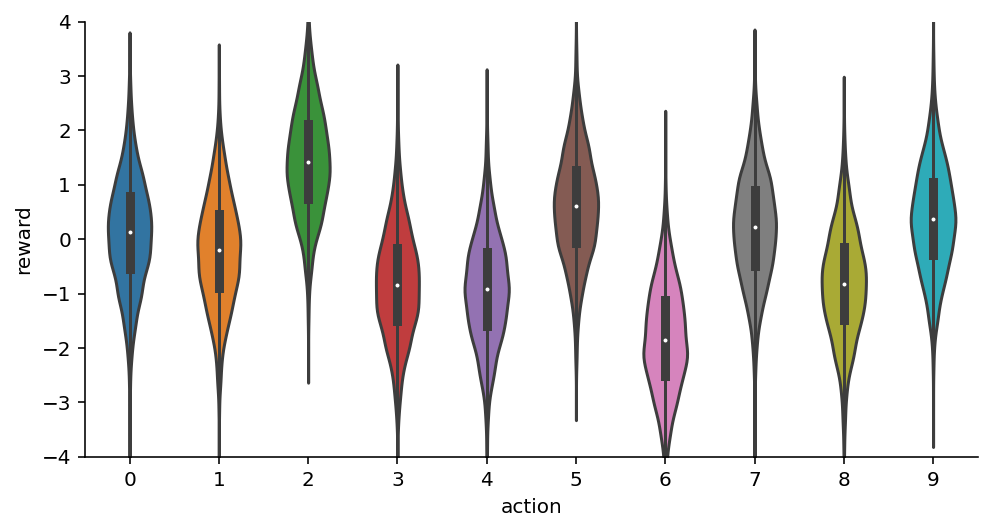

In [7]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)
plt.ylim(-4, 4)

## WAPR method

$$
    Q_{n+1} := Q_n + \alpha_n\left[ R_n - Q_n \right]
$$

where 

$$
    \sum_{n=1}^\infty \alpha_n = \infty \,,\qquad \sum_{n=1}^{\infty } \alpha_n^2 < \infty
$$

### Define $\alpha_n$

In [39]:
num_steps = 1000
eps = 0.1
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(3141)

In [61]:
def take_greedy(state, key, eps, alpha_n):
    num_visits, Qt = state
    key_action_random, key_action_greedy, key_reward, key_greedy = random.split(key, 4)
    
    #Qt = prev_Qt#cumulative_rewards / jnp.maximum(num_visits, 1)
    take_greedy = (jax.random.uniform(key_greedy) > eps) * 1.0
    
    map_choice = Qt.max() == Qt
    prob_choice_Q = map_choice / map_choice.sum()
    
    greedy_action = random.choice(key_action_greedy, bandits, p=prob_choice_Q)
    random_action = random.choice(key_action_random, bandits)
    
    action = take_greedy * greedy_action + (1 - take_greedy) * random_action
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    action_ohe = jax.nn.one_hot(action, n_bandits)
    num_visits = num_visits + action_ohe
    n = jnp.maximum(num_visits,1)
    Qt = Qt + action_ohe * alpha_n(n,1) * (reward - Qt)
    
    return (num_visits, Qt), (reward, action)


def epsilon_learn(key, eps, num_steps, alpha_n, init_rewards):
    keys = random.split(key, num_steps)
    take_greedy_eps = partial(take_greedy, eps=eps, alpha_n = alpha_n)
    num_visits = jnp.zeros_like(init_rewards)
    
    init_state = (num_visits, init_rewards)
    (num_visits, Qt), (reward_hist, action_hist) = jax.lax.scan(take_greedy_eps, init_state, keys)
    return (num_visits, Qt), (reward_hist, action_hist)


# Note: 
# 1. vmap (0, 0, None, None) is not the same as 'vmapping'
# 2. first over (0, None, None, None) and then over (None, 0, None, None).
# The behaviour of 1. is one-to-one, the behaviour of 2. is cross-product

# vmap over keys for multiple samples
epsilon_learn_vmap = jax.vmap(epsilon_learn, (0, None, None, None, None))
# vmap over c for multiple configurations
epsilon_learn_vmap = jax.vmap(epsilon_learn_vmap, (None, 0, None, None, None))

## Epsilon greedy

In [75]:
def alpha_n(n, a):
    return 1 / jnp.sqrt(n)

nsims = 2000
num_steps = 1000
init_rewards = jnp.zeros(n_bandits)

key = random.PRNGKey(314)
keys = random.split(key, nsims)
eps_values = jnp.array([0., 0.01, 0.1, 0.7])

_, (reward_sims_multiple, action_sims_multiple) = epsilon_learn_vmap(keys, eps_values, num_steps, alpha_n, init_rewards)

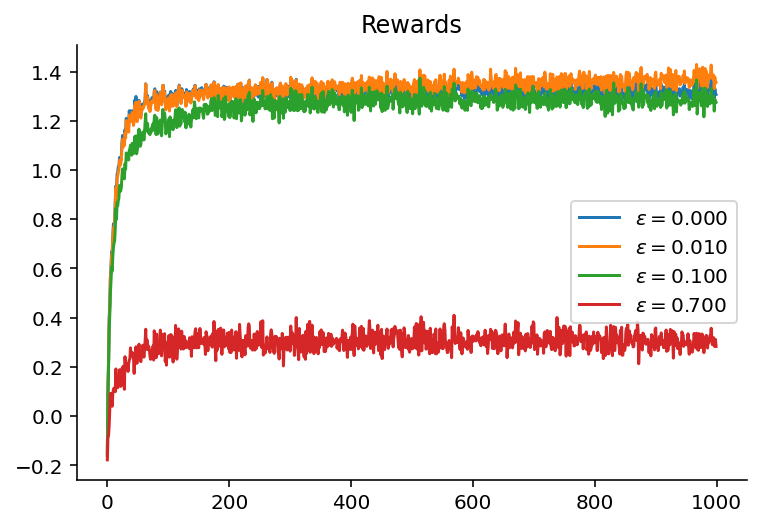

In [76]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.title("Rewards")
plt.legend(legends);

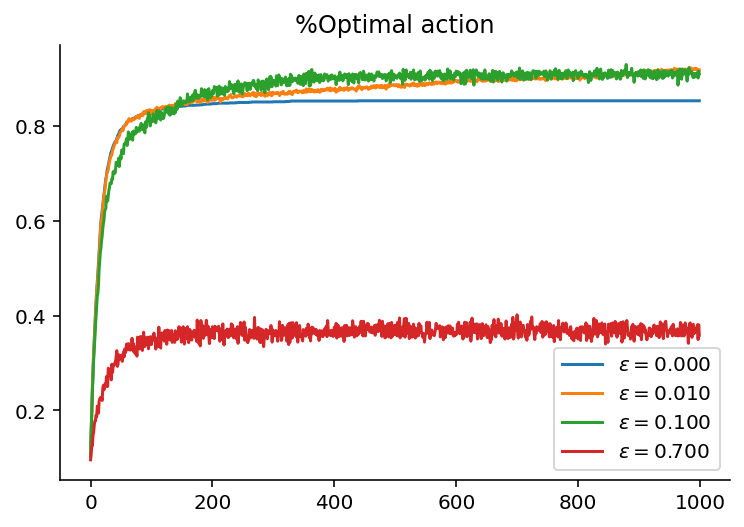

In [77]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.legend(legends);

## Second configuration

In [87]:
def alpha_n(n, a):
    return 1 / n

nsims = 2000
num_steps = 1000
init_rewards = jnp.zeros(n_bandits)

key = random.PRNGKey(314)
keys = random.split(key, nsims)
eps_values = jnp.array([0., 0.01, 0.1, 0.7])

_, (reward_sims_multiple, action_sims_multiple) = epsilon_learn_vmap(keys, eps_values, num_steps, alpha_n, init_rewards)

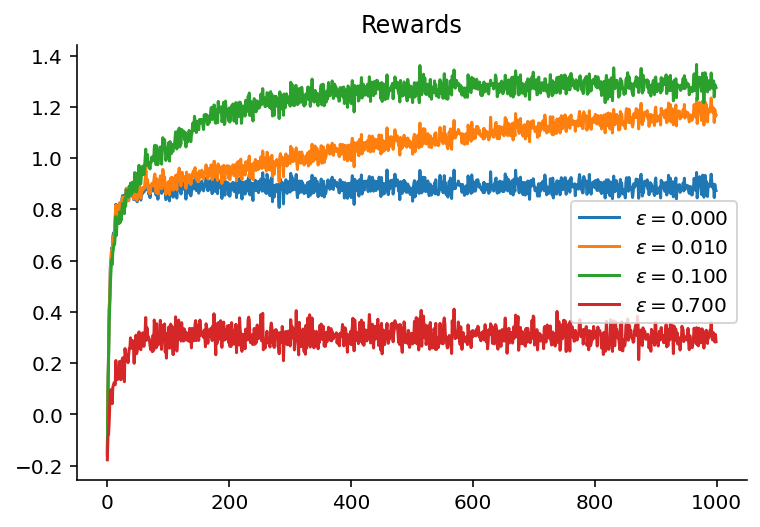

In [79]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.title("Rewards")
plt.legend(legends);

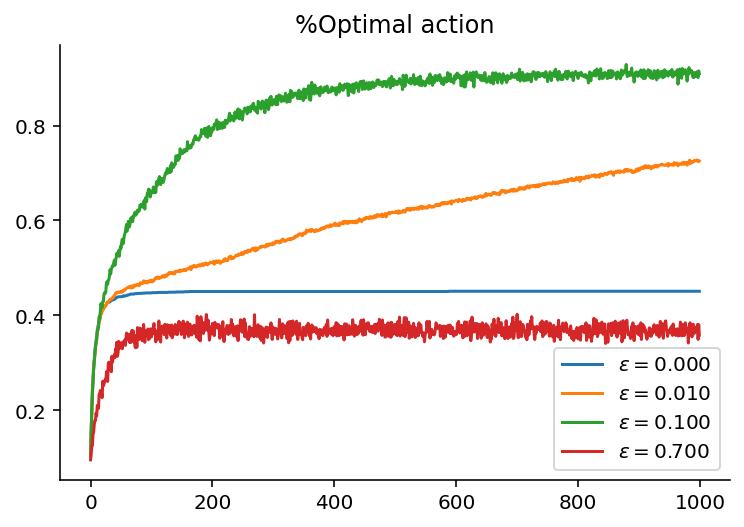

In [80]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.legend(legends);

## Third configuration

In [81]:
def alpha_n(n, a):
    return 1 / n ** 2

In [82]:
nsims = 2000
num_steps = 1000
init_rewards = jnp.zeros(n_bandits)

key = random.PRNGKey(314)
keys = random.split(key, nsims)
eps_values = jnp.array([0., 0.01, 0.1, 0.7])

_, (reward_sims_multiple, action_sims_multiple) = epsilon_learn_vmap(keys, eps_values, num_steps, alpha_n, init_rewards)

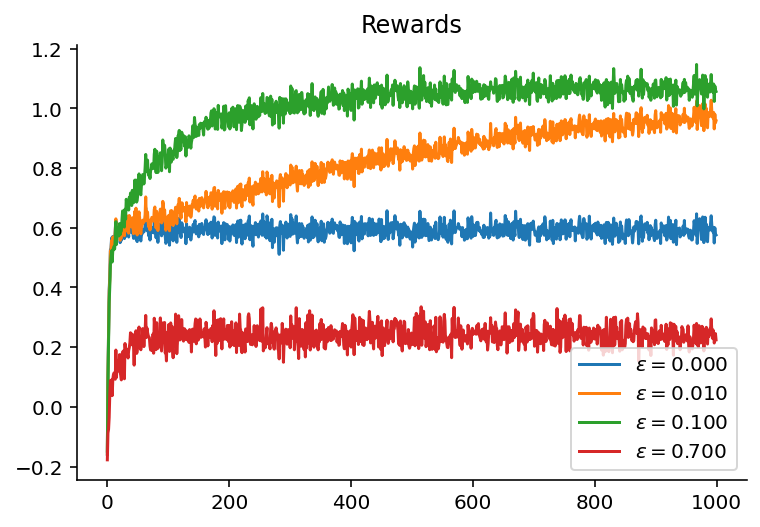

In [83]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.title("Rewards")
plt.legend(legends);

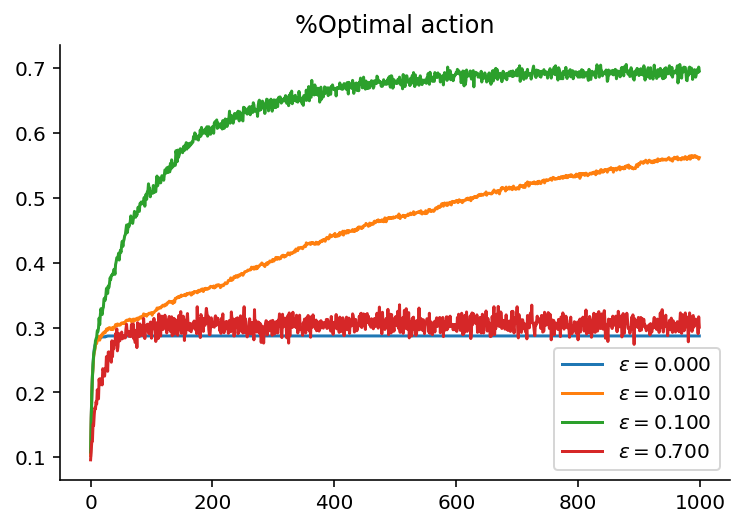

In [84]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.legend(legends);